# Deconvolution for the simulated mouse embryo data

## Data preprocessing

We generate simulated data using the `get_simulated_data` function. For data simulation, users must set the `distance` parameter to specify the radius for each simulated spot. By setting the `label_tag` parameter (`adata.obs[label_tag]`), our simulator can produce both the ground truth deconvolution (cell type proportion) matrix and the simulated spot labels, which represent the cell type of the highest proportion.

>>> INFO: Generate simulated ST data, simulated data shape (1368, 27554), average 10.788 cells in each spot. (1.19s).


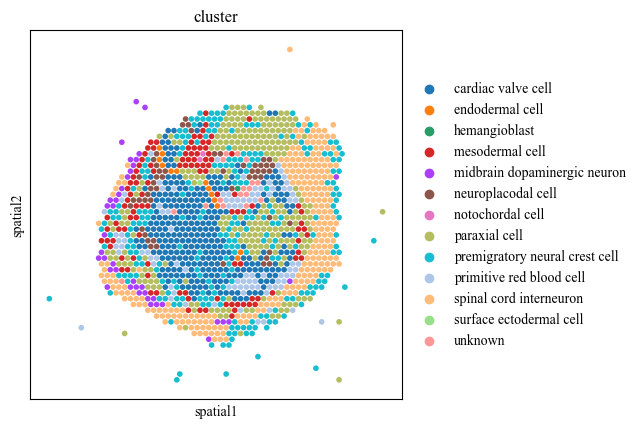

In [ ]:
import stSCI
import scanpy as sc
from stSCI.utils.simulate import get_simulated_data

adata = sc.read('data/mouse_embryo/embryo_e9.5_slideseq.h5ad')
sim_adata = get_simulated_data(adata, distance=50, label_tag='cell_type')
sc.pl.spatial(sim_adata, color='cluster', spot_size=50)

In [2]:
sc_adata = adata.copy()
st_adata = sim_adata.copy()

sc.pp.highly_variable_genes(sc_adata, flavor="seurat_v3", n_top_genes=6000)
sc.pp.highly_variable_genes(st_adata, flavor="seurat_v3", n_top_genes=6000)
sc.pp.normalize_total(sc_adata, target_sum=1e4)
sc.pp.normalize_total(st_adata, target_sum=1e4)
sc.pp.log1p(sc_adata)
sc.pp.log1p(st_adata)

## Model training

In [3]:
sc_adata, st_adata = stSCI.train(sc_adata, st_adata, hvg_count=6000, cluster_key='cell_type', deconvolution=True)

>>> INFO: Filtered 2235 genes.
>>> INFO: Find 3765 same HVGs, result data shapes: [(14758, 3765), (1368, 3765)].
>>> INFO: Generate 9576 edges, 6.000 edges per spot (0.01s).
>>> INFO: Finish PCA (0.49s).
>>> INFO: Finish centroid generation (0.50s).
>>> INFO: Finish centroid generation (0.13s).


>>> Train stSCI: 100%|██████████| 500/500 [00:42<00:00, 11.68it/s]


>>> INFO: Generate 58840 MNN pairs, 3.987 pairs per SC cell; 43.012 pairs per ST spot (0.18s).
>>> INFO: Finish generate deconvolution result (0.07s).
>>> INFO: Train stSCI model (46.53s).


## Evaluation

We provide the function `plot_deconvolution` to visualize the proportion for each cell.

>>> Predicted deconvolution result


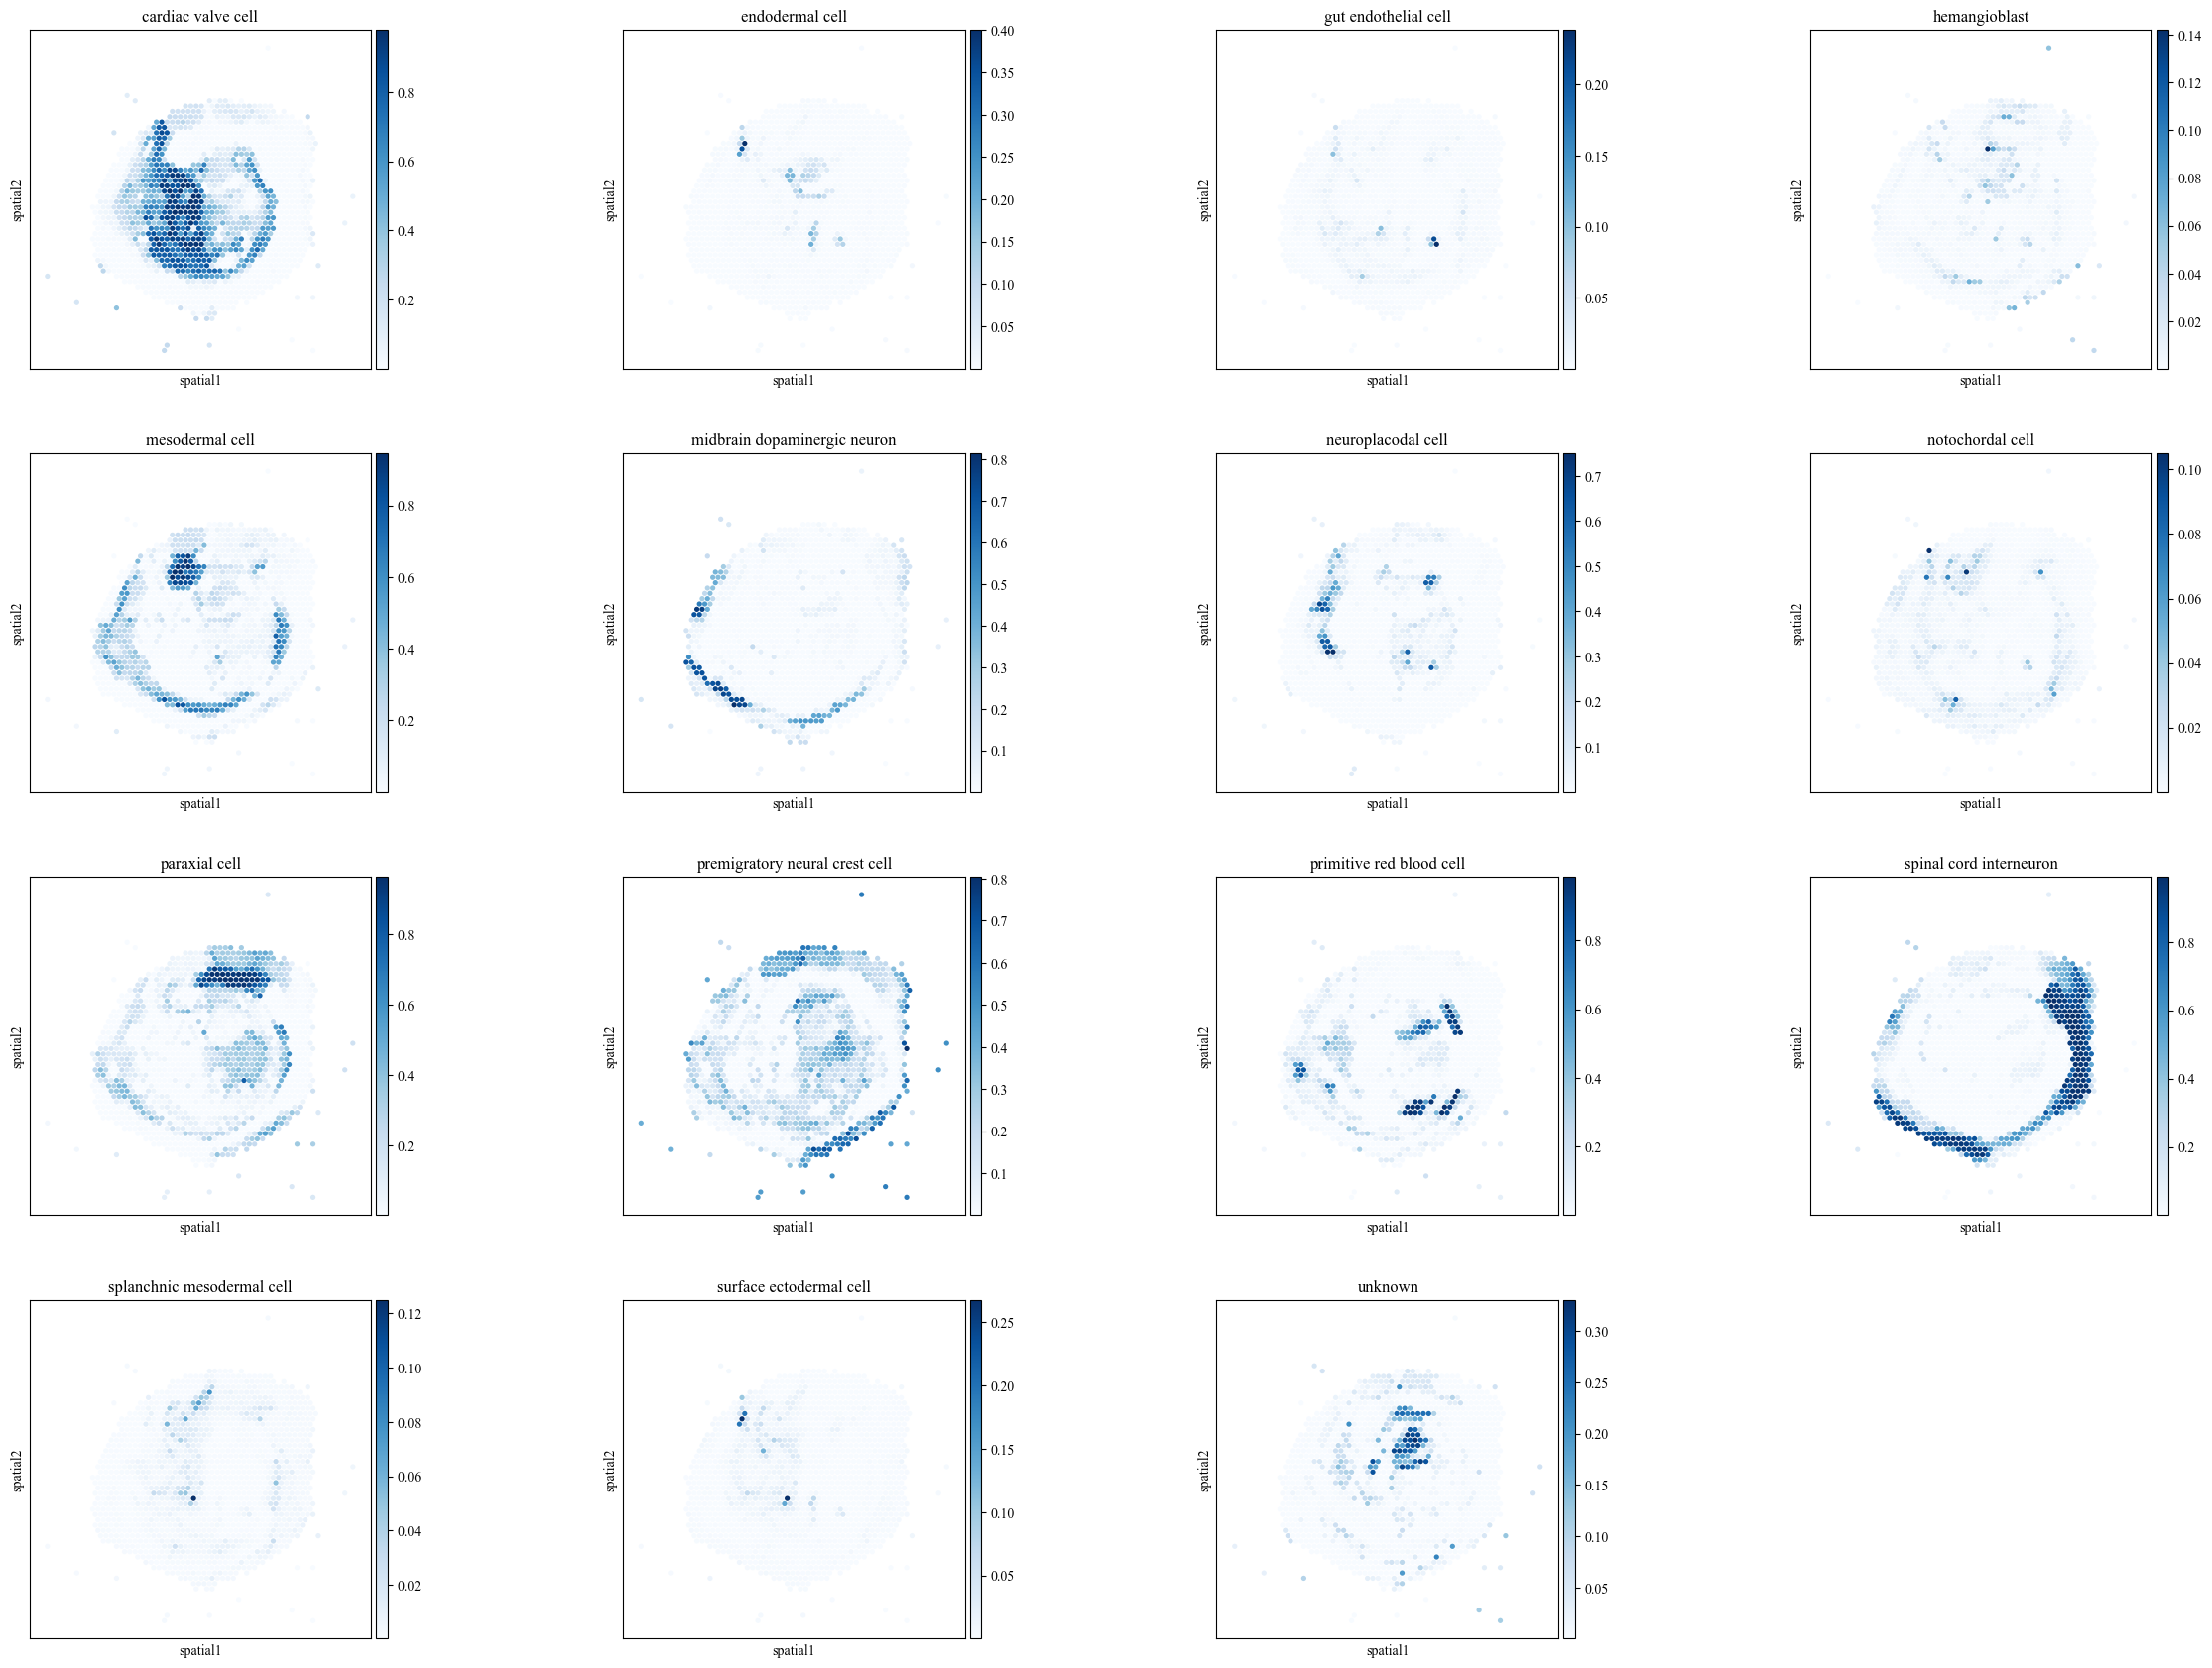

>>> Ground truth deconvolution result


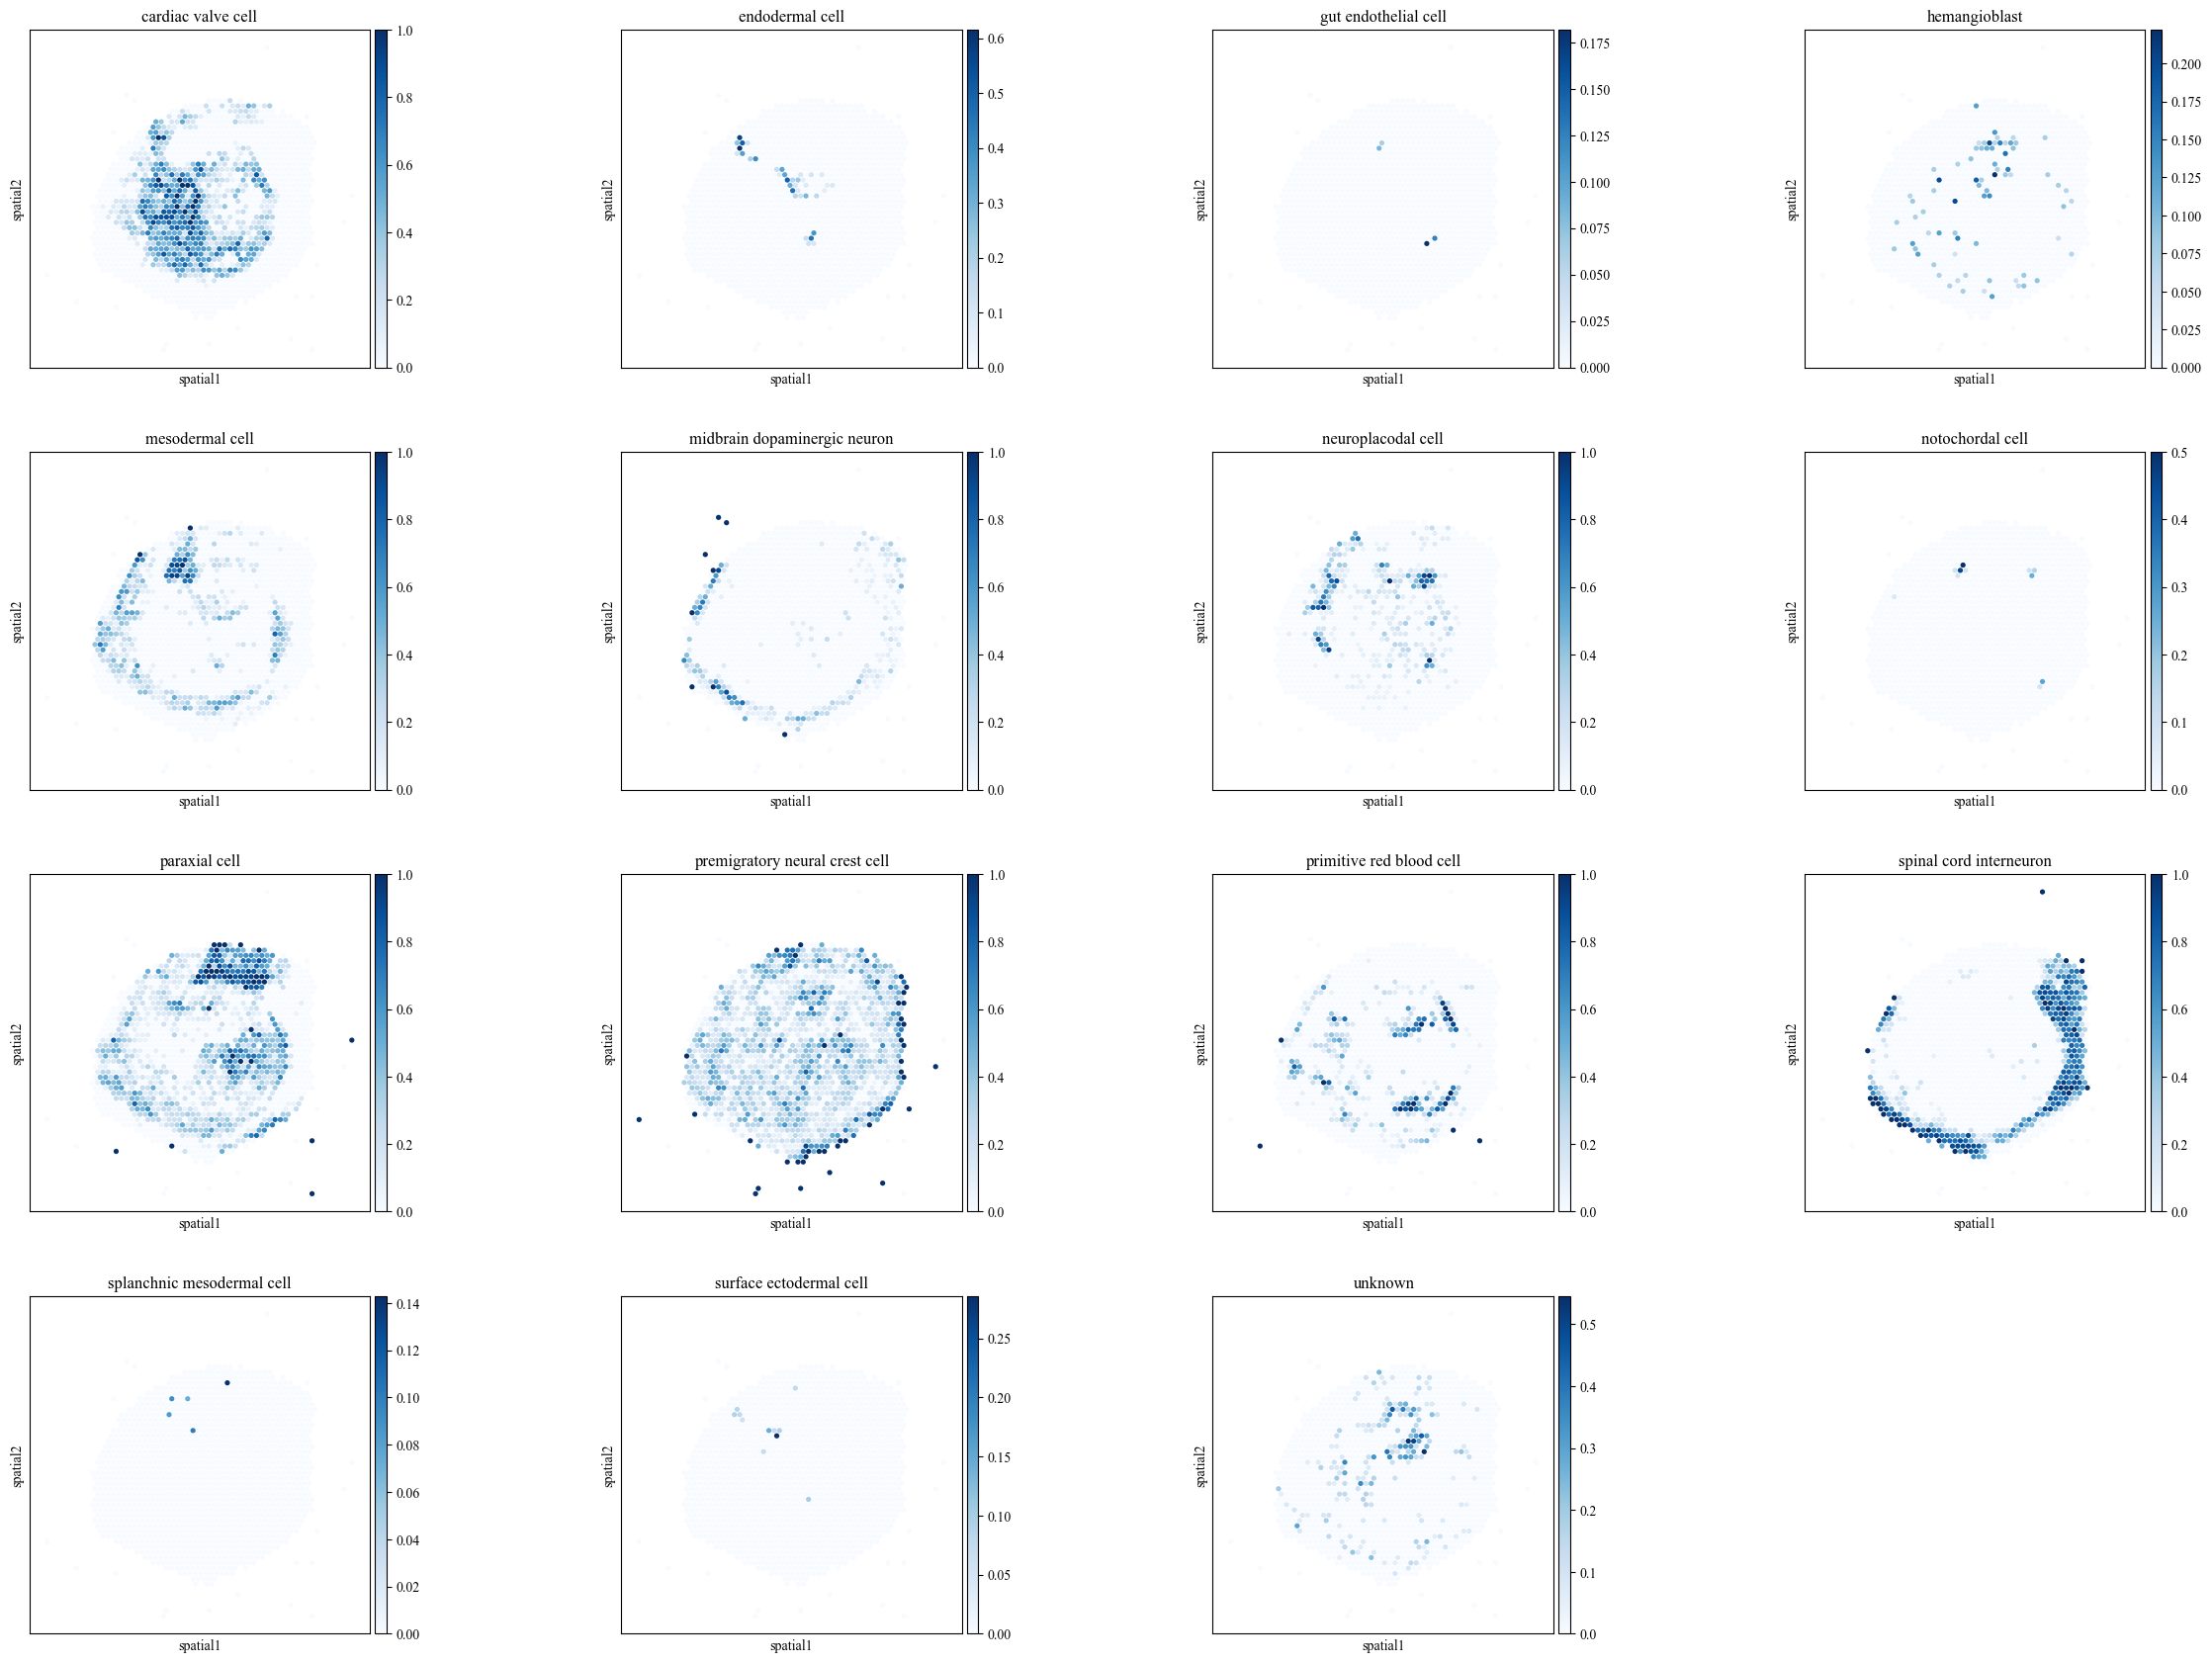

In [4]:
from stSCI.utils.plot import plot_deconvolution
plot_deconvolution(st_adata, spot_size=50)

We then further quantify the deconvolution result by the overall PCC, SSIM, RMSE, and JSD.

In [5]:
import st_datasets as stds
pcc_score = stds.metrics.cal_PCC(st_adata.obsm['deconvolution_result'].to_numpy(),
    st_adata.obsm['decon_result'][st_adata.obsm['deconvolution_result'].columns].to_numpy())
ssim_score = stds.metrics.cal_SSIM(st_adata.obsm['deconvolution_result'].to_numpy(),
    st_adata.obsm['decon_result'][st_adata.obsm['deconvolution_result'].columns].to_numpy())
rmse_score = stds.metrics.cal_RMSE(st_adata.obsm['deconvolution_result'].to_numpy(),
    st_adata.obsm['decon_result'][st_adata.obsm['deconvolution_result'].columns].to_numpy())
jsd_score = stds.metrics.cal_JSD(st_adata.obsm['deconvolution_result'].to_numpy(),
    st_adata.obsm['decon_result'][st_adata.obsm['deconvolution_result'].columns].to_numpy())
print(f"PCC: {pcc_score:.3f},", f"SSIM: {ssim_score:.3f},", f"RMSE: {rmse_score:.3f},", f"JSD: {jsd_score:.3f},")

PCC: 0.788, SSIM: 0.632, RMSE: 0.110, JSD: 0.539,
